# Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The value of the *RMSE* metric on the test sample should be no more than 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from the English *number of orders*, “number of orders”).

P.s initially the project was executed in Russian, and only then it was translated into English using an auto-translator, so errors or untranslated sections are possible.

## Prepropcessing

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data.index.duplicated().sum()

0

In [6]:
data = data.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


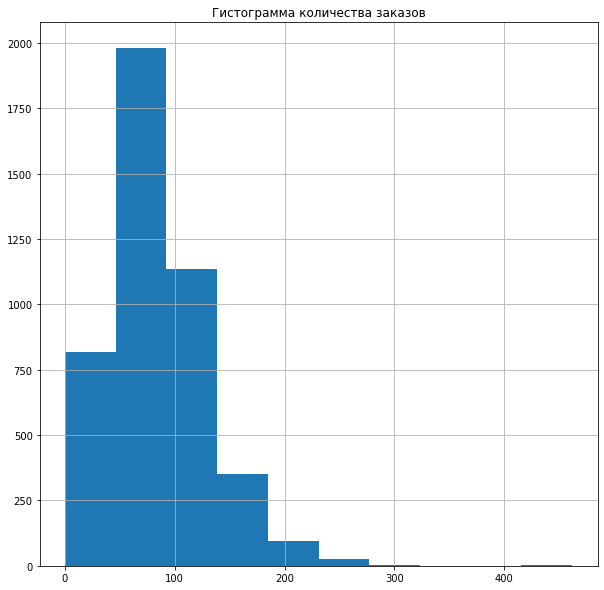

In [9]:
data.hist(figsize=(10,10));
plt.title('Гистограмма количества заказов');

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

### Review

In [11]:
def adf_test(timeseries):
    result = sm.tsa.adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

# Вызов функции для выполнения теста Дики-Фуллера
adf_test(data['num_orders'])

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The results of the Dickey-Fuller test do not allow us to claim that the series is stationary

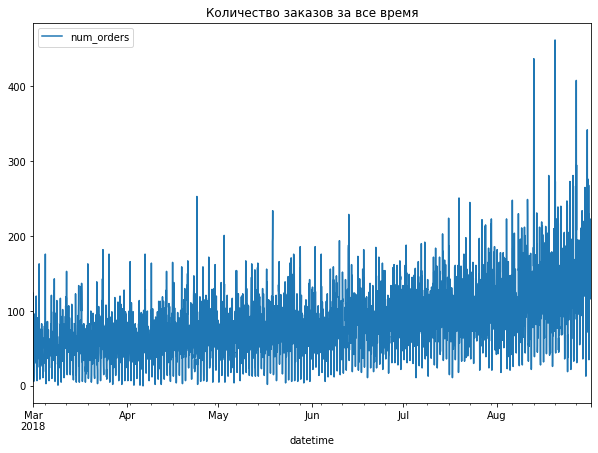

In [12]:
data.plot(figsize=(10,7));
plt.title('Количество заказов за все время');

### Time analysis

In [13]:
def time_parts(data):
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['day_of_week'] = data.index.day_of_week
    data['hour'] = data.index.hour
    return data

In [14]:
data = time_parts(data)

In [15]:
data.head()

,num_orders,day,month,day_of_week,hour
datetime,,,,,
2018-03-01 00:00:00,124,1,3,3,0
2018-03-01 01:00:00,85,1,3,3,1
2018-03-01 02:00:00,71,1,3,3,2
2018-03-01 03:00:00,66,1,3,3,3
2018-03-01 04:00:00,43,1,3,3,4


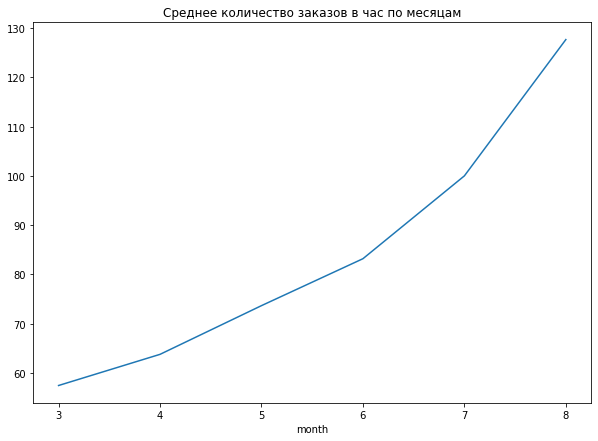

In [16]:
data.groupby('month')['num_orders'].mean().plot(figsize=(10,7));
plt.title('Среднее количество заказов в час по месяцам');

We see a clear upward trend

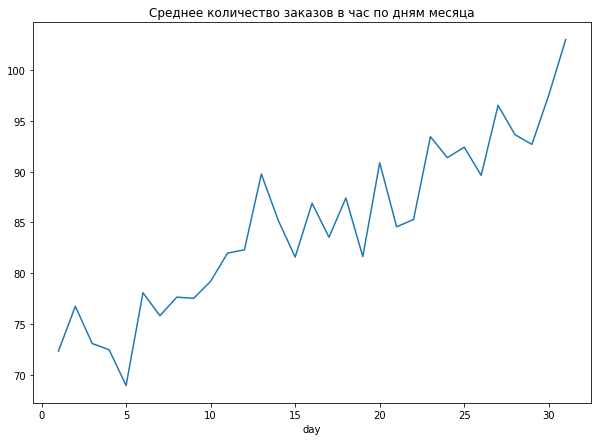

In [17]:
data.groupby('day')['num_orders'].mean().plot(figsize=(10,7));
plt.title('Среднее количество заказов в час по дням месяца');

There is also an upward trend within the month

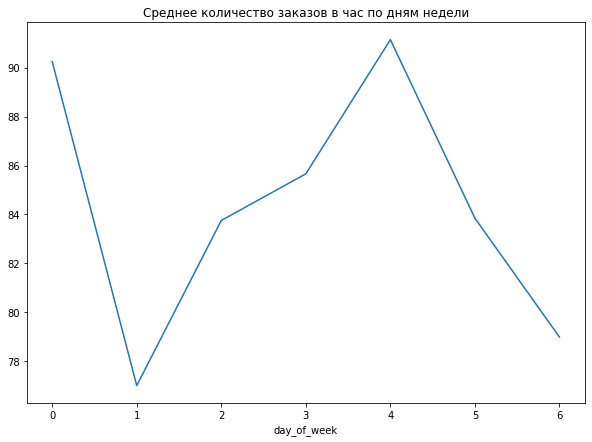

In [18]:
data.groupby('day_of_week')['num_orders'].mean().plot(figsize=(10,7));
plt.title('Среднее количество заказов в час по дням недели');

The most popular days are Monday and Friday, the least popular are Tuesday and Sunday.

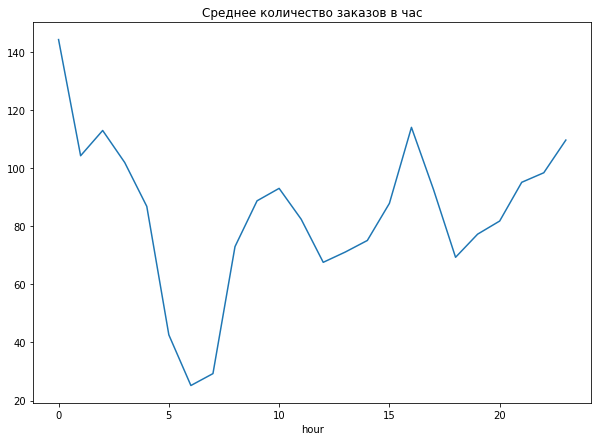

In [19]:
data.groupby('hour')['num_orders'].mean().plot(figsize=(10,7));
plt.title('Среднее количество заказов в час');

The most popular times are from 00:00 to 03:00, from 09:00 to 11:00 and from 15:00 to 23:59
Least popular - from 05:00 to 07:00

### Decomposition

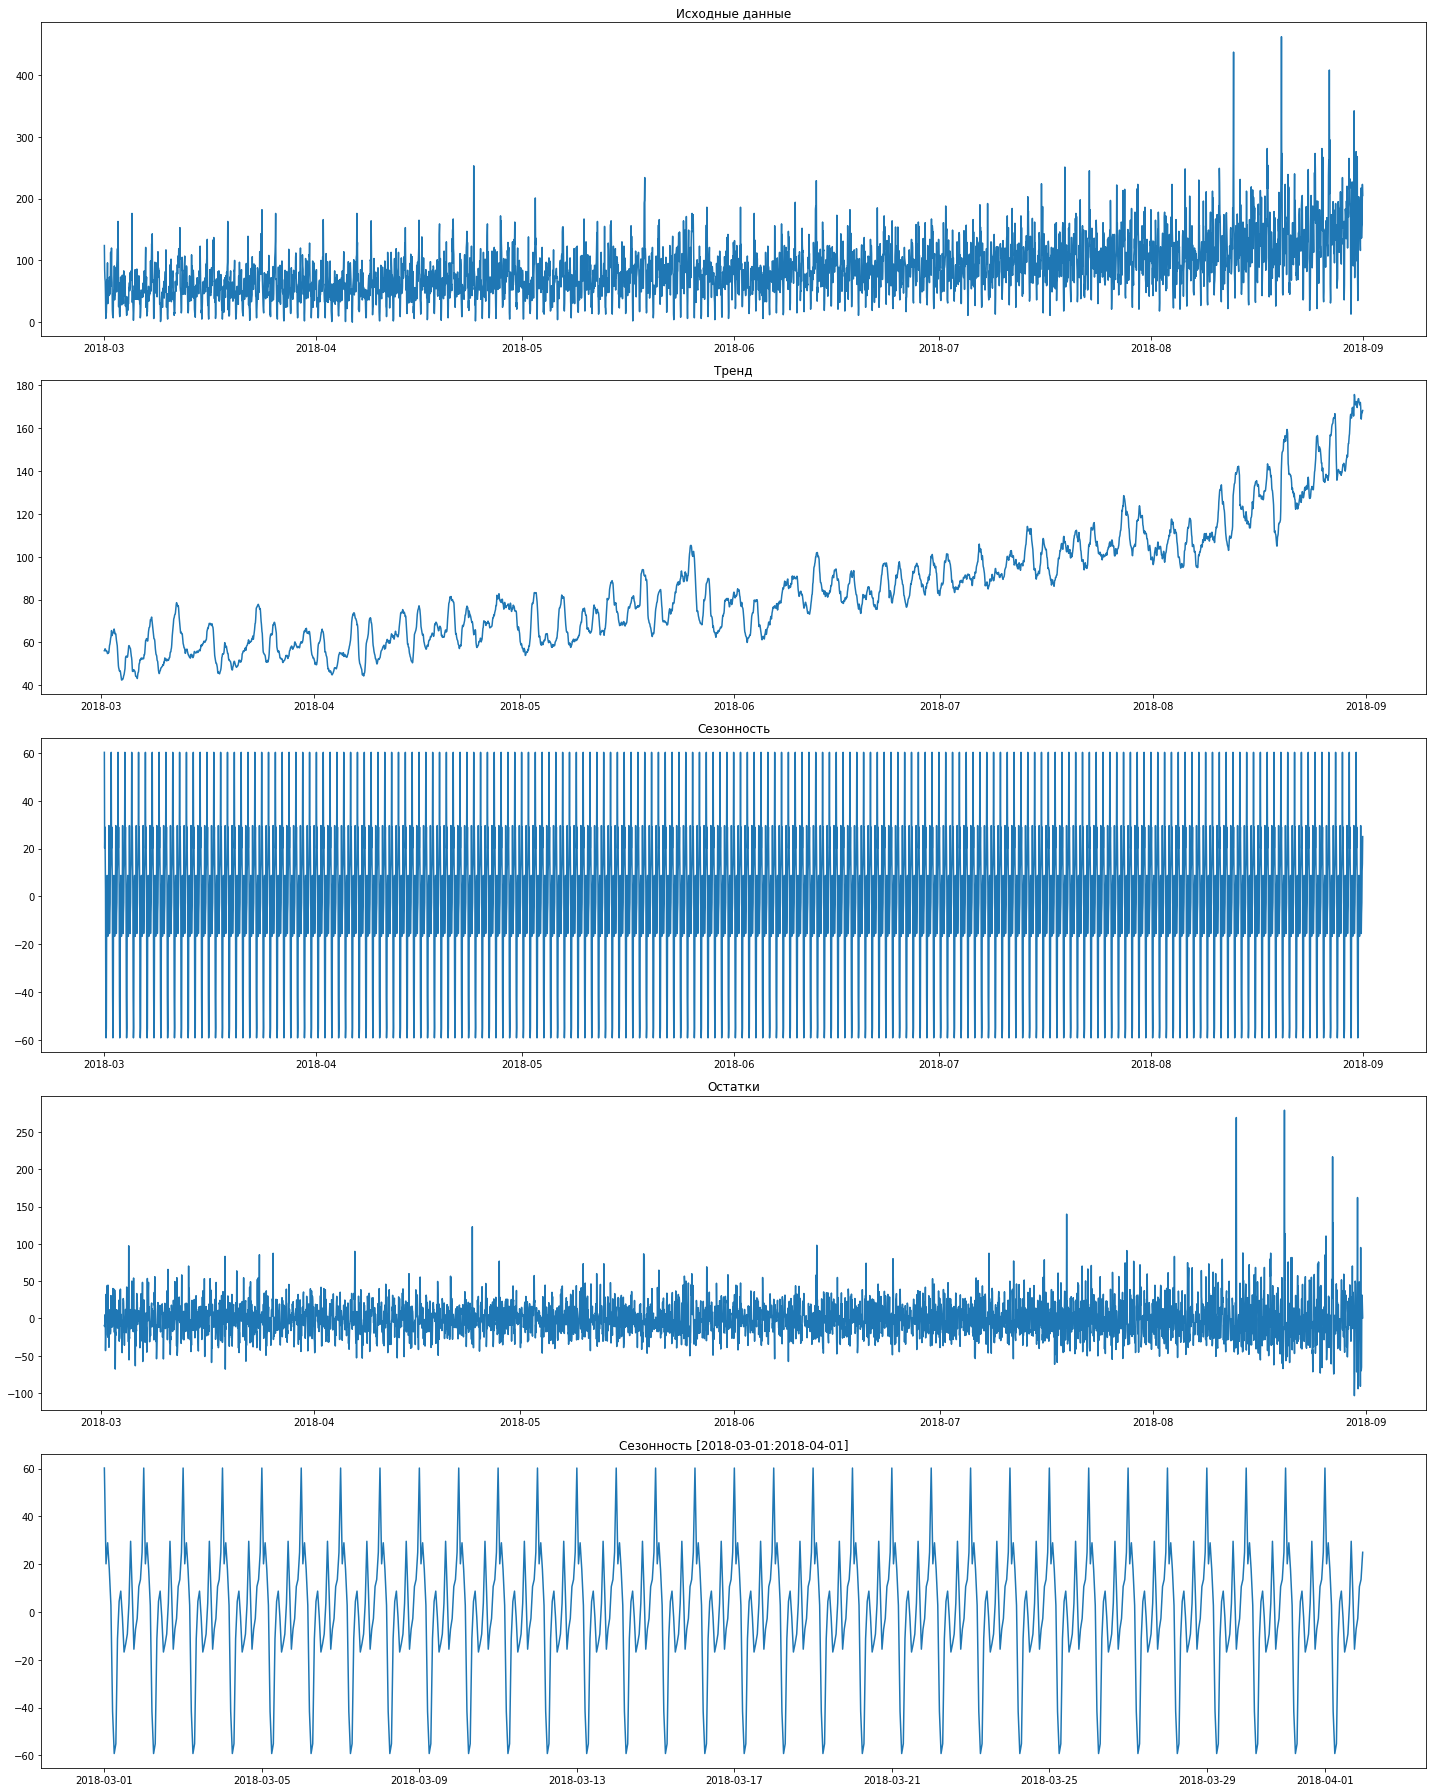

In [20]:
decomposition = sm.tsa.seasonal_decompose(data['num_orders'], model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
    
composed = trend + seasonal + residual
    
data['trend'] = trend
data['seasonal'] = seasonal
data['residual'] = residual
    
data[['trend','seasonal', 'residual']] = data[['trend','seasonal', 'residual']].shift(1)
    

plt.figure(figsize=(20, 25))

# Исходные данные
plt.subplot(5, 1, 1)
plt.plot(data['num_orders'])
plt.title('Исходные данные')

# Тренд
plt.subplot(5, 1, 2)
plt.plot(trend)
plt.title('Тренд')

# Сезонность
plt.subplot(5, 1, 3)
plt.plot(seasonal)
plt.title('Сезонность')

# Остатки
plt.subplot(5, 1, 4)
plt.plot(residual)
plt.title('Остатки')

# Сезонность для заданного диапазона дат ['2018-03-01':'2018-04-01']
plt.subplot(5, 1, 5)
plt.plot(seasonal['2018-03-01':'2018-04-01'])
plt.title('Сезонность [2018-03-01:2018-04-01]')

plt.tight_layout()
plt.show()

In [21]:
residual.describe()

count    4392.000000
mean       -0.008130
std        24.696896
min      -103.546496
25%       -14.730950
50%        -1.387969
75%        12.967052
max       279.371423
Name: resid, dtype: float64

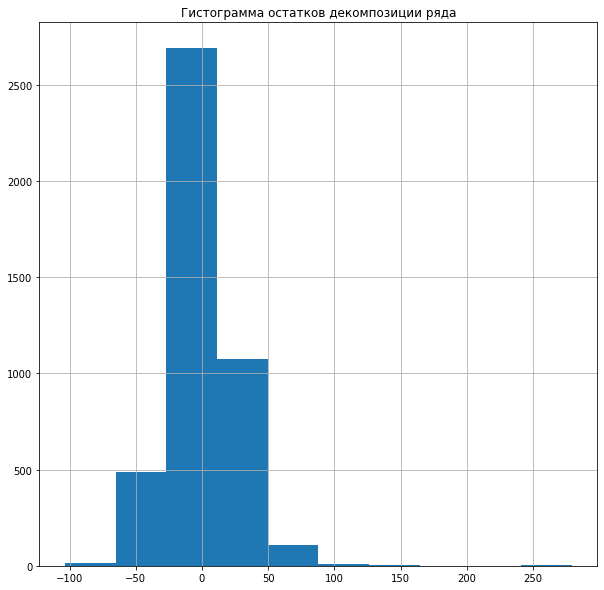

In [22]:
residual.hist(figsize=(10,10));
plt.title('Гистограмма остатков декомпозиции ряда');

    The decomposition indicates the presence of an upward trend, which is intensifying every month (most likely, two factors contribute to this: the growing popularity of airports in the summer and the growing popularity of the service as a whole).

    Decomposition also indicates the presence of a pronounced daily trend
    
    The shape of the distribution of residuals is generally similar to the normal distribution, which suggests that such a decomposition is correct

### Autocorrelation and significant lags

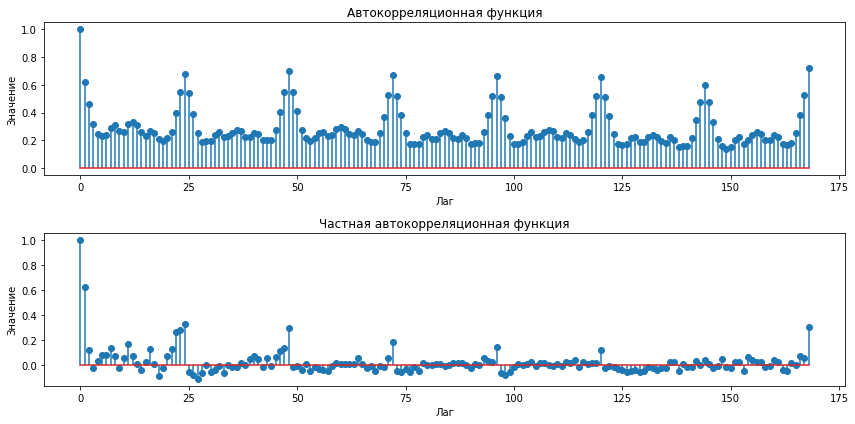

CPU times: user 47.4 s, sys: 13.4 s, total: 1min
Wall time: 1min 1s


In [23]:
%%time
autocorr = sm.tsa.acf(data['num_orders'], nlags=168)
pacf = sm.tsa.pacf(data['num_orders'], nlags=168)

# Визуализируем результаты
plt.figure(figsize=(12, 6))

# График автокорреляционной функции
plt.subplot(2, 1, 1)
plt.stem(autocorr, use_line_collection=True)
plt.xlabel('Лаг')
plt.ylabel('Значение')
plt.title('Автокорреляционная функция')

# График частной автокорреляционной функции
plt.subplot(2, 1, 2)
plt.stem(pacf, use_line_collection=True)
plt.xlabel('Лаг')
plt.ylabel('Значение')
plt.title('Частная автокорреляционная функция')

plt.tight_layout()
plt.show()

The most important lags: 1, 23, 24, 168

In [24]:
def add_shift(data, gap, col):
    data[f'{col}_shift_{gap}'] = data[col].shift(gap)
    return data

In [25]:
for i in [1, 23, 24, 168]:
    data = add_shift(data, i, 'num_orders')

### Moving average

In [26]:
def add_MA(df, ma):
    df[f'MA_{ma}'] = df.num_orders.shift(1).rolling(window=ma).mean()
    return df

In [27]:
for i in [*range(5,25,4)]+[24]:
    data = add_MA(data, i)

In [28]:
data.head(10)

,num_orders,day,month,day_of_week,hour,trend,seasonal,residual,num_orders_shift_1,num_orders_shift_23,num_orders_shift_24,num_orders_shift_168,MA_5,MA_9,MA_13,MA_17,MA_21,MA_24
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,1,NaN,60.248112,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,3,2,NaN,20.177074,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,3,NaN,28.982743,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,3,4,NaN,17.885407,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,3,5,NaN,2.791145,NaN,43.0,NaN,NaN,NaN,77.8,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,3,6,NaN,-41.563022,NaN,6.0,NaN,NaN,NaN,54.2,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,3,7,NaN,-59.182671,NaN,12.0,NaN,NaN,NaN,39.6,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,3,8,NaN,-55.104461,NaN,15.0,NaN,NaN,NaN,28.4,NaN,NaN,NaN,NaN,NaN


### Time encoding

In [29]:
def time_convert(data):
    periods = data.groupby('month').day.max()
    time_cols = ['day', 'month', 'day_of_week', 'hour']
    data['hour_x'] = np.sin(2*np.pi*data['hour']/24)
    data['hour_y'] = np.cos(2*np.pi*data['hour']/24)

    data['dayfloat'] = data['day'] + data['hour']/24
    data['monthfloat'] = data['month'] + data['dayfloat']/periods[data['month']].set_axis(data['dayfloat'].index)

    data['day_x'] = np.sin(2*np.pi*data['dayfloat']/periods[data['month']].set_axis(data['dayfloat'].index))
    data['day_y'] = np.cos(2*np.pi*data['dayfloat']/periods[data['month']].set_axis(data['dayfloat'].index))

    data['month_x'] = np.sin(2*np.pi*data['monthfloat']/12)
    data['month_y'] = np.cos(2*np.pi*data['monthfloat']/12)

    data['day_of_week_x'] = np.sin(2*np.pi*data['day_of_week']/7)
    data['day_of_week_y'] = np.cos(2*np.pi*data['day_of_week']/7)
    return data

In [30]:
data = time_convert(data)

In [31]:
data = data.drop(['day', 'month', 'hour', 'day_of_week', 'dayfloat', 'monthfloat'], axis=1)

In [32]:
data = data.dropna()

In [33]:
data.head()

,num_orders,trend,seasonal,residual,num_orders_shift_1,num_orders_shift_23,num_orders_shift_24,num_orders_shift_168,MA_5,MA_9,...,MA_21,MA_24,hour_x,hour_y,day_x,day_y,month_x,month_y,day_of_week_x,day_of_week_y
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,66.125000,25.000503,2.874497,94.0,121.0,100.0,124.0,91.0,77.666667,...,56.952381,60.041667,0.000000,1.000000,0.998717,-0.050649,0.990885,-0.134711,0.433884,-0.900969
2018-03-08 01:00:00,78,66.875000,60.248112,15.876888,143.0,24.0,121.0,85.0,109.6,87.888889,...,60.619048,61.833333,0.258819,0.965926,0.998253,-0.059082,0.990790,-0.135409,0.433884,-0.900969
2018-03-08 02:00:00,65,67.000000,20.177074,-9.177074,78.0,66.0,24.0,71.0,110.0,91.444444,...,60.857143,60.041667,0.500000,0.866025,0.997719,-0.067510,0.990694,-0.136106,0.433884,-0.900969
2018-03-08 03:00:00,68,67.229167,28.982743,-31.211910,65.0,73.0,66.0,66.0,101.4,93.333333,...,63.476190,61.750000,0.707107,0.707107,0.997113,-0.075933,0.990598,-0.136803,0.433884,-0.900969
2018-03-08 04:00:00,60,68.187500,17.885407,-18.072907,68.0,10.0,73.0,43.0,89.6,89.888889,...,65.809524,61.833333,0.866025,0.500000,0.996436,-0.084351,0.990502,-0.137500,0.433884,-0.900969


## Training

In [34]:
train, test = train_test_split(data, test_size = 0.1, shuffle=False)
train_features = train.drop('num_orders',axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders',axis=1)
test_target = test['num_orders']

In [35]:
def scale_data(train_features, test_features):
    scaler = StandardScaler()
    scaler.fit(train_features)
    train_features = scaler.transform(train_features)
    test_features = scaler.transform(test_features)
    return train_features, test_features

In [36]:
train_features, test_features = scale_data(train_features, test_features)

In [37]:
def update_best_params(best_params, model_name, params, rmse):
    if model_name not in best_params or rmse < best_params[model_name]['rmse']:
        best_params[model_name] = {'params': params, 'rmse': rmse}

In [38]:
%%time
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store the RMSE for each model
rmse_lin_list = []
rmse_cat_list = []
rmse_knn_list = []
rmse_rf_list = []
rmse_lw_list = []

best_params = {}


for train_index, test_index in tscv.split(train_features):
    # Split the data into train and test sets based on TimeSeriesSplit
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_target[train_index], train_target[test_index]
    
    # Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    predictions_lin = lin_model.predict(X_test)
    rmse_lin = np.sqrt(mean_squared_error(y_test, predictions_lin)).round(0)
    rmse_lin_list.append(rmse_lin)

# CatBoost Model
grid_cat = {
    'iterations': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}
for params in ParameterGrid(grid_cat):
    for train_index, test_index in tscv.split(train_features):
        X_train, X_test = train_features[train_index], train_features[test_index]
        y_train, y_test = train_target[train_index], train_target[test_index]
        cat_model = CatBoostRegressor(verbose=False)
        cat_model.set_params(**params)
        cat_model.fit(X_train, y_train)
        predictions_cat = cat_model.predict(X_test)
        rmse_cat = np.sqrt(mean_squared_error(y_test, predictions_cat)).round(0)
        rmse_cat_list.append(rmse_cat)
    update_best_params(best_params, 'CatBoost', params, np.mean(rmse_cat_list))
    
# KNN Regression
grid_knn = {
    'n_neighbors': [3, 5, 7]
}
for params in ParameterGrid(grid_knn):
    for train_index, test_index in tscv.split(train_features):
        X_train, X_test = train_features[train_index], train_features[test_index]
        y_train, y_test = train_target[train_index], train_target[test_index]
        knn_model = KNeighborsRegressor()
        knn_model.set_params(**params)
        knn_model.fit(X_train, y_train)
        predictions_knn = knn_model.predict(X_test)
        rmse_knn = np.sqrt(mean_squared_error(y_test, predictions_knn)).round(0)
        rmse_knn_list.append(rmse_knn)
    update_best_params(best_params, 'KNN Regression', params, np.mean(rmse_knn_list))        
   

#RF Regression
grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
for params in ParameterGrid(grid_rf):
    for train_index, test_index in tscv.split(train_features):
        X_train, X_test = train_features[train_index], train_features[test_index]
        y_train, y_test = train_target[train_index], train_target[test_index]
        rf_model = RandomForestRegressor()
        rf_model.set_params(**params)
        rf_model.fit(X_train, y_train)
        predictions_rf = rf_model.predict(X_test)
        rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf)).round(0)
        rmse_rf_list.append(rmse_knn)
    update_best_params(best_params, 'RF Regression', params, np.mean(rmse_rf_list))


# Last_week predict
predictions_lw = data.loc[y_test.index]['num_orders_shift_168']
rmse_lw = np.sqrt(mean_squared_error(y_test, predictions_lw)).round(0)
rmse_lw_list.append(rmse_lw)

# Calculate the mean RMSE for each model
mean_rmse_lin = np.mean(rmse_lin_list)
mean_rmse_cat = best_params['CatBoost']['rmse']
mean_rmse_knn = best_params['KNN Regression']['rmse']
mean_rmse_rf = best_params['RF Regression']['rmse']
mean_rmse_lw = np.mean(rmse_lw_list)

print("Mean RMSE - Linear Regression:", mean_rmse_lin)
print("Mean RMSE - CatBoost:", mean_rmse_cat.round(0))
print("Mean RMSE - KNN Regression:", mean_rmse_knn.round(0))
print("Mean RMSE - RF Regression:", mean_rmse_rf.round(0))
print("Mean RMSE - Last Week Prediction:", mean_rmse_lw)


Mean RMSE - Linear Regression: 22.0
Mean RMSE - CatBoost: 22.0
Mean RMSE - KNN Regression: 26.0
Mean RMSE - RF Regression: 32.0
Mean RMSE - Last Week Prediction: 32.0
CPU times: user 9min 52s, sys: 5.61 s, total: 9min 58s
Wall time: 10min 30s


Total:
    
    1. The best models - CatBoostRegression: RMSE_test = 22, LinearRegression: RMSE_test = 22
    
    2. Other models show RMSE_test = [26:32]
    
    3. Last week’s values ​​are off by an average of 32 orders.
   
For the test sample I will use a linear regression model

## Testing

In [39]:
model = LinearRegression()
model.fit(train_features, train_target)
predictions_lin = model.predict(test_features)
rmse_lin_test = np.sqrt(mean_squared_error(test_target, predictions_lin)).round(0)
print('RMSE_test LinearRegression:', rmse_lin_test)

RMSE_test LinearRegression: 35.0


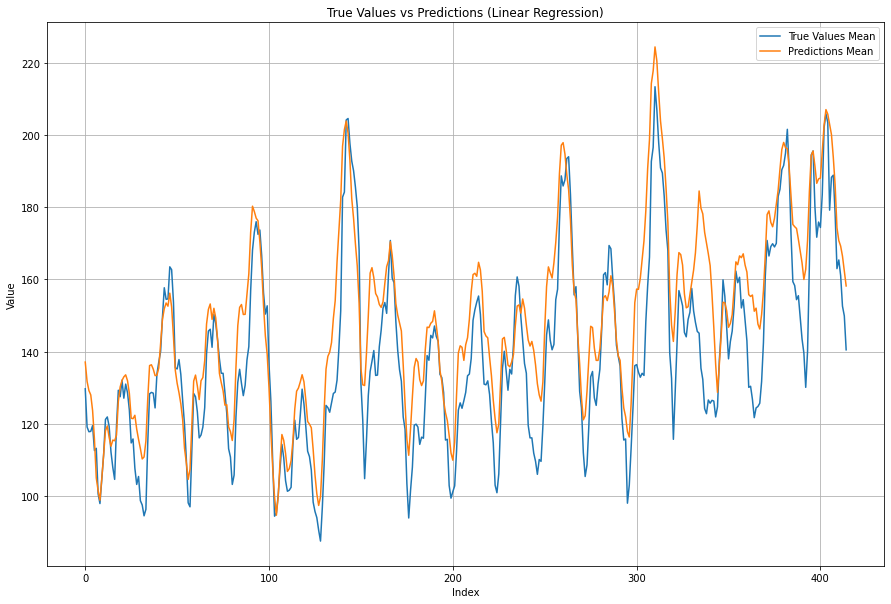

In [67]:
plt.figure(figsize=(15, 10))  
test_target_df = pd.DataFrame(test_target)
predictions_lin_df = pd.DataFrame(predictions_lin)

test_target_df['mean'] = test_target_df['num_orders'].rolling(window=10).mean()
predictions_lin_df['mean'] = predictions_lin_df[0].rolling(window=10).mean()

indices = range(len(test_target_df['mean'].dropna()))
# Plot the true values and predicted values
plt.plot(indices, test_target_df['mean'].dropna(), label='True Values Mean')
plt.plot(indices, predictions_lin_df['mean'].dropna(), label='Predictions Mean')

# Set plot labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True Values vs Predictions (Linear Regression)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

The best result is shown by LinearRegression, RMSE = 35, which is lower than required. The resulting model can be used to predict the number of orders for the next hour